In [1]:
# imports and stuff
import os
os.chdir('../..')  # we're in $CAFFE_ROOT/examples/swwae
import sys
sys.path.insert(0, './python')
import caffe
from google.protobuf import text_format
import caffe.draw
from caffe.proto import caffe_pb2
from pylab import *
%matplotlib inline

In [14]:
# set up solver
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/swwae/solver.prototxt')

In [15]:
# find most recent caffemodel or start training from scratch if there's none
import re
def atoi(text): return int(text) if text.isdigit() else text
def natural_keys(text): return [atoi(c) for c in re.split('(\d+)', text)]

os.listdir('examples/swwae/modelfiles')

solverstates = [fn for fn in os.listdir('examples/swwae/modelfiles') if fn.endswith(".solverstate")]
solverstates.sort()
snapshots = [fn for fn in os.listdir('examples/swwae/modelfiles') if fn.endswith(".caffemodel")]
snapshots.sort()

if len(snapshots)>1:
    solver.net.copy_from('examples/swwae/modelfiles/' + snapshots[-1])

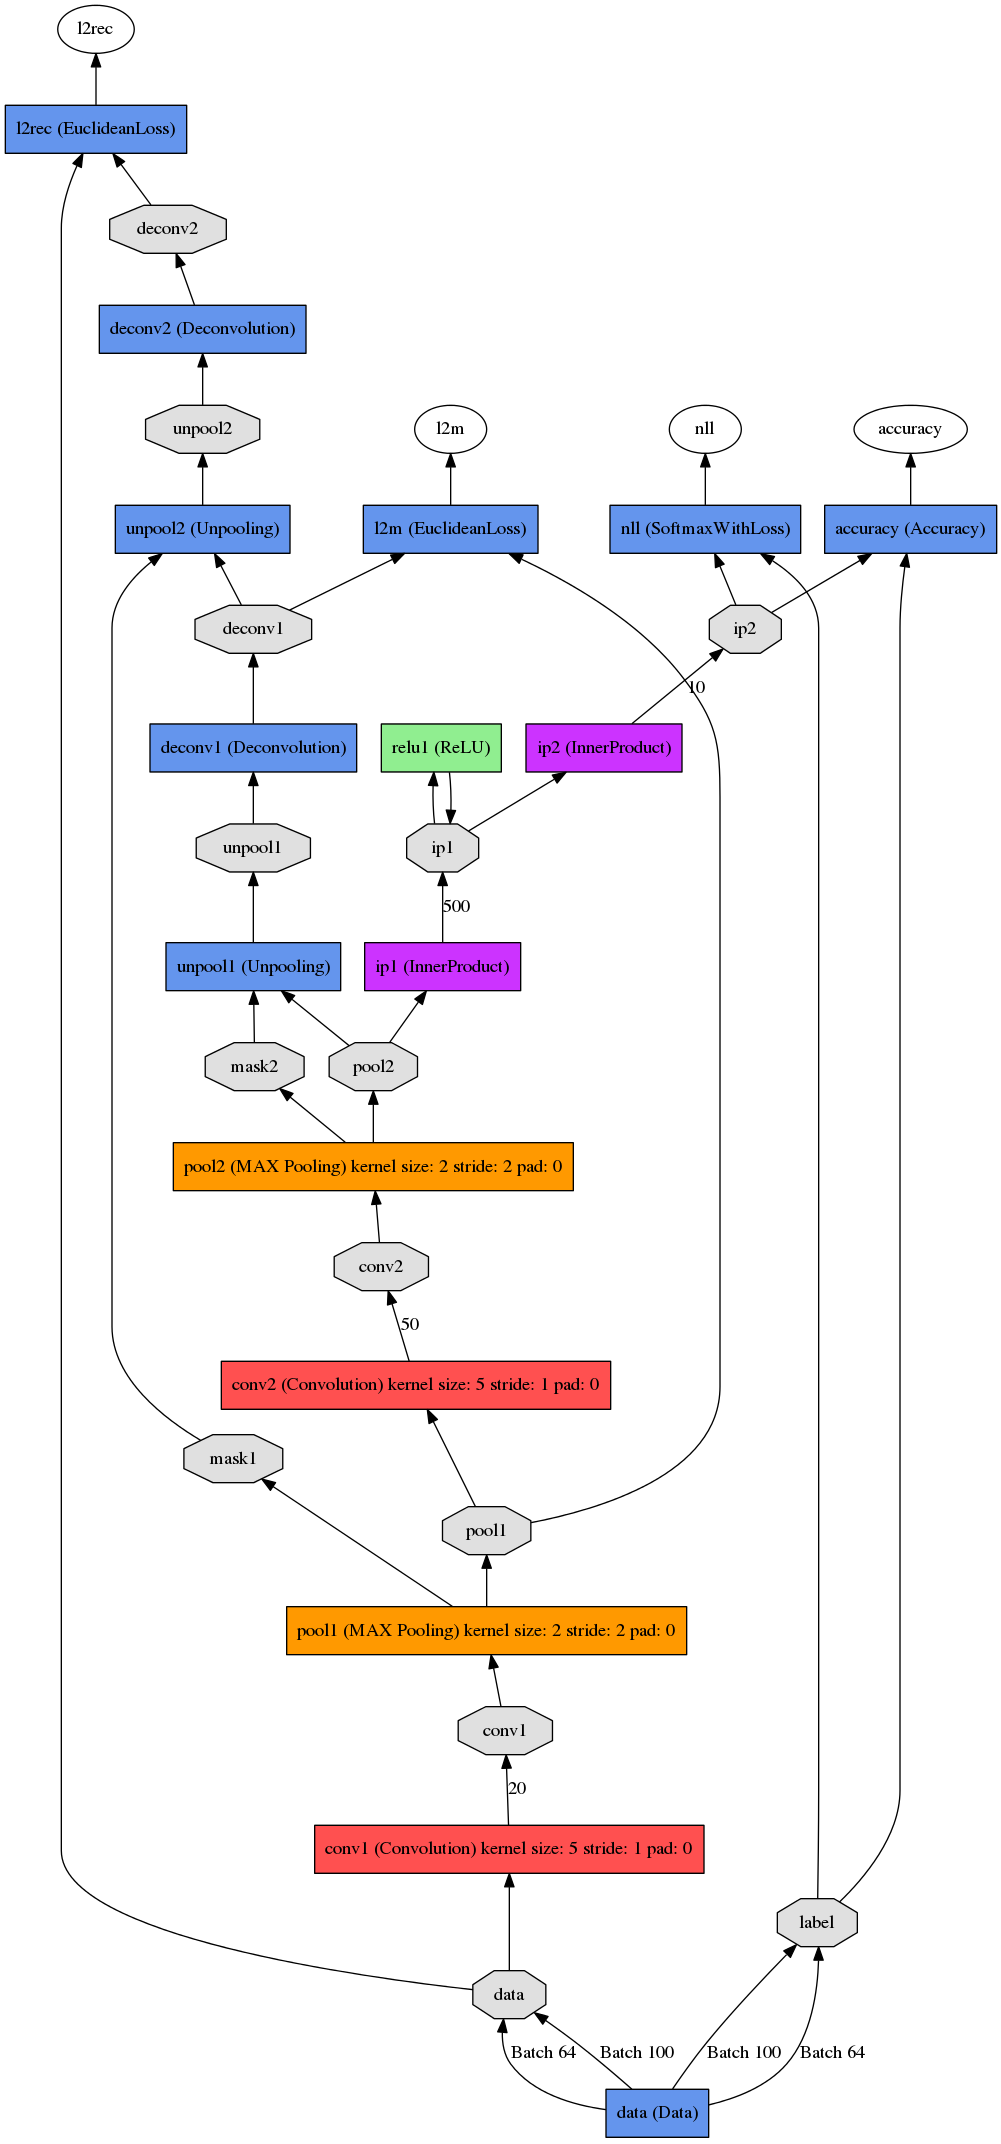

In [11]:
# draw and display the net
from IPython.display import Image
net = caffe_pb2.NetParameter()
text_format.Merge(open('examples/swwae/train.prototxt').read(), net)
caffe.draw.draw_net_to_file(net, 'examples/swwae/net_figure.png', 'BT')

Image(filename='examples/swwae/net_figure.png')

In [ ]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

In [12]:
# run training
niter = 1
test_interval = 10
train_loss = zeros(niter)
reconstr_loss = zeros(niter)
intermediate_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# store pool2, mask2, unpool1
pool2_maps = zeros((niter,)+solver.net.blobs['pool2'].data[0,5].shape)
mask2_maps = zeros((niter,)+solver.net.blobs['mask2'].data[0,5].shape)
conv2_maps = zeros((niter,)+solver.net.blobs['conv2'].data[0,5].shape)
unpool1_maps = zeros((niter,)+solver.net.blobs['unpool1'].data[0,5].shape)

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['nll'].data
    reconstr_loss[it] = solver.net.blobs['l2rec'].data
    intermediate_loss[it] = solver.net.blobs['l2m'].data
    
    # store feature maps
    pool2_maps[it] = solver.net.blobs['pool2'].data[0,5]
    mask2_maps[it] = solver.net.blobs['mask2'].data[0,5]
    unpool1_maps[it] = solver.net.blobs['unpool1'].data[0,5]
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
        print 'nll: ', train_loss[it], ' l2rec: ', reconstr_loss[it], ' l2m: ', intermediate_loss[it]

Iteration 0 testing...


IndexError: index 0 is out of bounds for axis 0 with size 0

In [65]:
# shorthand for showing feature maps
def print_map(blob_name, c=0, cmap='gray'):
    figure(figsize=tuple(map(lambda x: max(x/12,0.5), solver.net.blobs[blob_name].data[0,c].shape)))
    imshow(solver.net.blobs[blob_name].data[0,c], cmap)
    title(blob_name + ' (c=' + str(c) +')')
    matplotlib.pyplot.axis('off')

In [16]:
# one iteration

solver.step(1)  # SGD by Caffe

# store the train loss
train_loss[it] = solver.net.blobs['nll'].data
reconstr_loss[it] = solver.net.blobs['l2rec'].data
intermediate_loss[it] = solver.net.blobs['l2m'].data

# store feature maps
pool2_maps[it] = solver.net.blobs['pool2'].data[0,5]
mask2_maps[it] = solver.net.blobs['mask2'].data[0,5]
unpool1_maps[it] = solver.net.blobs['unpool1'].data[0,5]

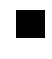

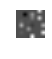

In [17]:

matplotlib.pyplot.close('all')
for it in range(niter):
    figure(figsize=tuple(map(lambda x: max(x/12,0.5), pool2_maps[0].shape)))
    imshow(conv2_maps[it], cmap='gray')
    matplotlib.pyplot.axis('off')
    
    figure(figsize=tuple(map(lambda x: max(x/12,0.5), pool2_maps[0].shape)))
    imshow(unpool1_maps[it], cmap='gray')
    matplotlib.pyplot.axis('off')

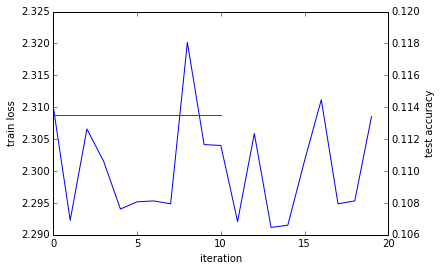

In [80]:
# plot progress
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

In [25]:
#imshow(solver.net.params['deconv1'][0].diff[:, 0].reshape(4, 5, 5, 5).transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')
imshow(solver.net.params['deconv1'][0].data[0:9, 0].reshape(3, 3, 5, 5).transpose(0, 2, 1, 3).reshape(3*3, 3*3), cmap='gray')

ValueError: total size of new array must be unchanged

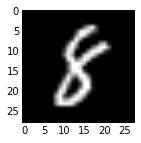

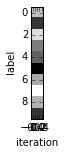

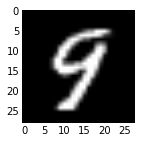

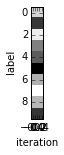

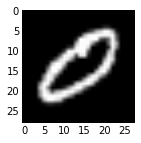

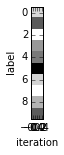

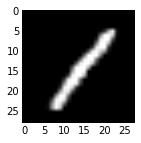

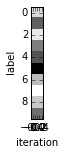

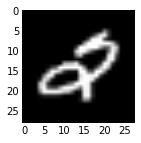

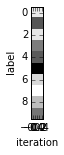

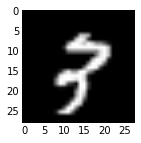

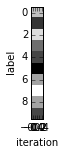

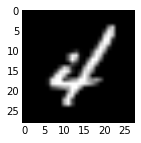

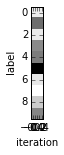

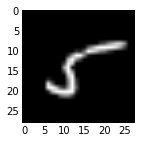

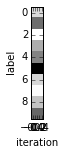

In [18]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')